# Tensor Networks and Quantum Simulations
# Tutorial 2

Perimeter Institute

Quantum and AI Career Trajectories Mini-Course: Computational Methods and their Applications

May 11, 2023

In [1]:
import numpy as np
import tensornetwork as tn
import scipy as sp
import time
import pickle
import matplotlib.pyplot as plt

## Measuring observables

Gauging the state is very convenient when measuring local observables! The diagram we originally would have to calculate to measure some observable $O$ at site 3 would have been

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1ygT6TC5gudXN-3tD4X5dKFxQHzbHcpAy" width="700">
 </h2>

However, if the state is normalized and gauged correctly, the diagram reduces to

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1OOzU0O9KTfCwmd9r81pVymQtSFLm1a-e" width="100">
 </h2>

**Exercise 1** : Write a function that takes in a finite MPS, and observable $O$, and measures it for every site. 

Hints:
* Remember to move the center position around using state.position()
* Think about the contraction order, what would be the most optimal one?

In [2]:
def measure_local(state,O):
    measured = []
    
    ### Solution to Exercise 1: ###
    for loc in range(len(state)):
        state.position(loc)
        measured.append(tn.ncon([state.tensors[loc],tn.conj(state.tensors[loc]),O],[[1,2,3],[1,4,3],[4,2]]))
    return np.array(measured)

## Density matrix renormalization group

In the following we'll use the DMRG algorithm to produce an MPS aproximation to the ground state of the transverse field Ising model. 
The `tensornetwork` library has already a simple DMRG algorithm implemented for us, and we will use it in the following to produce the MPS ground-state approximation.

SS-DMRG sweep=4/4, site=1/64: optimized E=-81.12598009932351    
dmrg did not converge to desired precision 1e-10 after 4 iterations



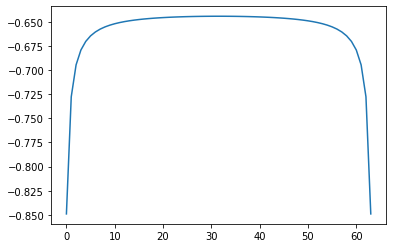

In [3]:
D = 16 # bond dimension of the MPS
N = 64 # number of spins in the system
J = 1.0 # interaction parameter
B = 1 # magnetic field strength
Jx = J * np.ones(N-1) # vector of interactions, one per spin-pair
Bz = B * np.ones(N) # local magnetic fields per spin
ising_mpo = tn.FiniteTFI(Jx, Bz, dtype=np.float64) # an MPO representation of the Hamiltonian for the TFI
mps = tn.FiniteMPS.random(D = [D]*(N-1), d = [2] * N, dtype=np.float64) # an initial random MPS

mps.position(0) # move the center of orthogonality to the first site of the chain

dmrg = tn.FiniteDMRG(mps, ising_mpo) #DMRG interface
dmrg.run_one_site(num_sweeps = 4, verbose=1, precision=1E-10) # run DMRG optimization

print()
sz = np.diag([-1,1]) # pauli-z operator
sx = np.array([[0,1],[1,0]]) # pauli-x operator
sz_obs = measure_local(mps,sz) # list of observables
plt.plot(sz_obs)

For small magnetic fields the ground state of the Ising model is a (anti) ferromagnet (depending on the sign of J), i.e. there is a local order parameter, the magnetic field, which is non-zero. As one increases the transverse field strength, the local magnetization decreases, until it eventually vanishes. At the exact point where the order parameter vanishes, the system has a criticial point, and the ground state is gapless (in the thermodynamic limit). 

**Exercise 2:** Using the DMRG interface of the `tensornetwork` package, run ground-state simulations for 20 values of the magnetic field $B_z$ between 0 and 1.5, and try to roughly locate the phase transition points. For that purpose, measure the bulk magnetization in $x$ direction of the ground state, say at the center site, for all values of $B_z$, and plot the results.

In [4]:
order_param = []
Bvalues = np.append(np.append(np.linspace(0, 0.8, 5), np.linspace(0.82,1.2, 20)), np.linspace(1.22, 1.5, 5))

### exercise 2: your code here
for B in Bvalues:
  Bz = B * np.ones(N) # local magnetic fields per spin
  ising_mpo = tn.FiniteTFI(Jx, Bz, dtype=np.float64) # an MPO representation of the Hamiltonian for the TFI
  tempmps = tn.FiniteMPS.random(D = [D]*(N-1), d = [2] * N, dtype=np.float64) # an initial random MPS
  dmrg = tn.FiniteDMRG(tempmps, ising_mpo) #DMRG interface
  dmrg.run_one_site(num_sweeps = 4, verbose=1, precision=1E-10) # run DMRG optimization
  sx_obs = measure_local(tempmps,sx) # list of observables
  order_param.append(np.abs(sx_obs[N//2]))

SS-DMRG sweep=4/4, site=1/64: optimized E=-74.69351668835343    
dmrg did not converge to desired precision 1e-10 after 4 iterations
SS-DMRG sweep=4/4, site=1/64: optimized E=-75.31182531201537    
dmrg did not converge to desired precision 1e-10 after 4 iterations
SS-DMRG sweep=4/4, site=1/64: optimized E=-75.9507428413591     
dmrg did not converge to desired precision 1e-10 after 4 iterations
SS-DMRG sweep=4/4, site=1/64: optimized E=-76.61116268293806    
dmrg did not converge to desired precision 1e-10 after 4 iterations
SS-DMRG sweep=4/4, site=1/64: optimized E=-77.2942450658037     
dmrg did not converge to desired precision 1e-10 after 4 iterations
SS-DMRG sweep=4/4, site=1/64: optimized E=-78.00174274324391    
dmrg did not converge to desired precision 1e-10 after 4 iterations
SS-DMRG sweep=4/4, site=1/64: optimized E=-78.73574146806328    
dmrg did not converge to desired precision 1e-10 after 4 iterations
SS-DMRG sweep=4/4, site=1/64: optimized E=-79.49954299957656    
dmrg

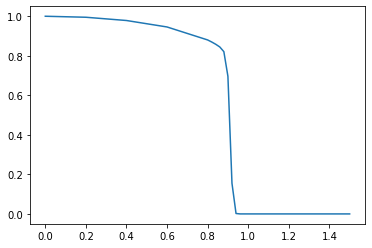

In [5]:
plt.plot(Bvalues, order_param)

## Correlation functions


Correlation functions are calculated as follows

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1yCxxF1FoIKGjbq18zyY7q8IXJOrasZ0c" width="700">
</h2>

**Exercise 3**: Write a function that takes in a start-position, a stop-position, a state and an observable, and calculates the correlation function $\langle O_i O_j \rangle$ for $i$ = start, and for all $j$ smaller than stop. 

In [6]:
def measure_corr(state,start,stop,O):
    state.position(start) # bring orthogonality center to `start`
    data = []
    ### exercise 3: your code here
    left = tn.ncon([state.tensors[start],tn.conj(state.tensors[start]),O],[[1,2,-2],[1,3,-1],[3,2]])
    for loc in range(start+1,stop):
        ### Solution to Exercise 2: ###
        data.append(tn.ncon([left,state.tensors[loc],tn.conj(state.tensors[loc]),O],[[1,2],[2,3,4],[1,5,4],[5,3]]))
        left = tn.ncon([left,state.tensors[loc],tn.conj(state.tensors[loc])],[[1,2],[2,3,-2],[1,3,-1]])
        
    return data

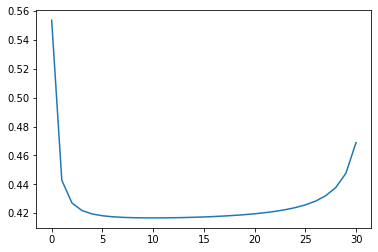

In [7]:
sz = np.diag([-1,1])
sz_obs = measure_corr(mps,31,63,sz)
plt.plot(sz_obs)

## Compressing an MPS

Now it's time to write our first real MPS algorithm - compressing a state to a lower virtual dimension. 
We will do this in typical MPS-fashion, by sweeping through the state and updating every tensor individually. For example, in the diagram below we update tensor $t_i$ using an SV decomposition:

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1TZBDLmVoq8rSI6UEVh5C-Qys6Hy8kUaZ" width="900">
</h2>

where the dimension of the first leg of $C$ has a lower dimension than its second leg. 

It is important that the the MPS has been gauged such that site $i$ is the centerposition! In this case the problem reduces to

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1q_V1M9TgQttDoSsNOeIvc5P_sGVP_Edw" width="400">
</h2>

We need a low rank decomposition of a single tensor - which is exactly what the singular value decomposition gives us!


Our approach will therefore be as follows:

* place the center at position $i$
* perform an svd ($= U,S,V$)
* the updated tensor will be $U$ will be the new MPS tensor at site $i$
* $S$, $V$ will be absorbed in the next site $i+1$, where the procedure is repeated.
    
**Exercise 4**: Complete the `compress_mps` function below. Use the `np.linalg.svd` to perform the SVD.



In [8]:
def compress_mps(mps_tensors, new_D):
    # mps_tensors here is a list of MPS tensors. 
    # You can assume that the orthogonality center is at position 0

    # we first make a copy of the list of tensors
    new_mps_tensors  = list(mps_tensors)

    # now sweep from left to right and do svd
    for loc in range(len(mps_tensors)-1):
        t = new_mps_tensors[loc]
        t_shape = t.shape
        ##### exercise 4: write the code to perform the SVD of the MPS tensor t

        # reshape the tensor and at position `loc` into a matrix and do svd
        U, S, V = np.linalg.svd(np.reshape(t, (t_shape[0]*t_shape[1], t_shape[2])))
        # truncate the SVD from above such that the maximum number of singular values
        # kept is D = min(new_D, t_shape[2])


        D = min(new_D, t.shape[2])

        ###### Exercise 4: fill in the code to truncate the bond dimension to a value of D
        U = U[:,:D]
        S = S[:D]
        V = V[:D, :]

        C = np.diag(S) @ V
        # update the tensor at loc with truncated U from above, and multiply the remainder 
        # diag(S) @ V to the right-next tensor of the mps
        new_mps_tensors[loc] = U.reshape(t_shape[0], t_shape[1], D)

        ######## Exercise 4: fill in the code to multiply C the the next-right tensor of the MPS
        new_mps_tensors[loc+1] = tn.ncon([C,new_mps_tensors[loc+1]],[[-1,1],[1,-2,-3]])
    # return the new tensors 
    return new_mps_tensors

We will test our new function on the groundstate of the Ising model that we obtained above. We will evaluate how observable change under truncation of the wave function.

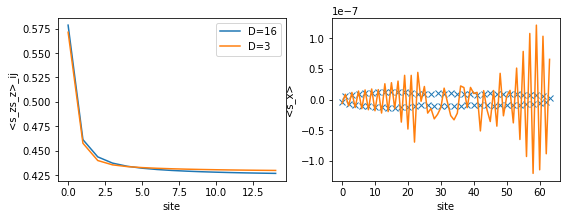

In [9]:
new_D = 3

sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])

local_orig = measure_local(mps,sx)
corr_orig = measure_corr(mps,6,22,sz)
mps.position(0)
mps_tensors_compressed = compress_mps(mps.tensors,new_D)    

# now compress the state
mps_compressed = tn.FiniteMPS(mps_tensors_compressed)

#make sure to move center site to site 0 prior to measurement
mps_compressed.position(0)

local_new = measure_local(mps_compressed,sx)
corr_new = measure_corr(mps_compressed,6,22,sz)

plt.figure(figsize=(9,3))

plt.subplot(121)
plt.plot(corr_orig, label=f'D={D}')
plt.plot(corr_new, label=f'D={new_D}')
plt.xlabel('site')
plt.ylabel('<s_zs_z>_ij')
plt.legend()
plt.subplot(122)
plt.plot(local_orig, 'x', label=f'D={D}')
plt.plot(local_new, label=f'D={new_D}')
plt.xlabel('site')
plt.ylabel('<s_x>')

plt.show()

We ca onbserve that the correlation function seems more susceptible to error upon trunction. This is in fact a general observation, and typically observed in MPS calculations. Correlation functions are notoriously more difficult to converge with bond dimension than local observables.

## Time evolution

In the following we will implement one of the simplest and also most widely used method to evolve a quantum state forward in time, the TEBD algorithm (invented by Guifre Vidal ~2004). The TEBD algorithm breakes the propagtor $\exp (-itH)$ into a product of small time steps $\exp(-idtH)$, and applies an approximate Trotter-Susuki breakup of the exponential $\exp(-idt H)$ into two non-commuting parts, each of which can be applied to the state a t hand to evolve it forward over a small time step $dt$. 

In more detail, the propagator 

$
\exp(-idtH) = \exp\left(-idt (\sum_{j=even} h_j + \sum_{j=odd}h_j)\right)
$

We will assume translational invariane, hence all $h_i$ are actually identical, but act at different sites. For that reason we will drop the index $i$ in diagrams if no confusion can occur. 
The Trotter-Suzuki breakup makes the approximation

$
\exp(-idtH) \approx \exp(-idt \sum_{j=even} h_j) \exp(-idt\sum_{j=odd}h_j)
$

Each $h_j$ acts on the two consecutive sites $j, j+1$. All operators within the even sum hence commute with each other (as do the operators within the odd sum). Hence, we can further break this apart into 

$
\exp(-idt\sum_{j=even}) =\prod_{j=even}\exp(-idth_j) 
$

and similar for the odd sum.

The exponentials $\exp(-idt h_j)$ are easy to compute, they are just two-by-two matrices, and have the following diagrammatic notation:

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1BRGfVmmjUOWWEgfA-lCBbI_0qeJMpJ7B" width="300">
</h2>

The evolution of an initial MPS $|\psi\rangle$ over a small period of time $dt$ under a nearest-neighbor Hamiltonian $H$ can then be drawn as the following diagram:

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1mAHhD8J58RXZ2ADyf8W2ANipKRWIg3W5" width="700">
</h2>

For a single time step one may be able to contract this exactly, and represent the result as a new MPS, albeit at the cost of increasing the bond dimension by a factor of two every time we apply a gate to a bond. Repeated application of this process will lead to an exponentially increasing bond dimension. This is a serious problem!! In order to make some progress, we thus truncate the MPS back to its original bond dimension after each application of a gate. Remember: we want to perform optimal truncation, so prior to truncating, we have to bring the orthogonality center of the MPS to the bond we want to truncate. 

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1A5tED17Q3si1RCdwA0W-X0Dh2B99HTOG" width="600">
</h2>

**Exercise 5**: Implement the  time-evolving block decimation (TEBD) algorithm by filling in the parts of the code marked `...` below.

Note: Instead of truncating the SVD to some fixed bond dimension, we will use the option max_truncation_err to control the smallest kept singular value. We will for this exercise make use of the function `mps.apply_two_site_gate`, which will handle most of the heavy lifting for us. Take a look at the docstring of this function:
```
"""
  def apply_two_site_gate(self,
                          gate: Tensor,
                          site1: int,
                          site2: int,
                          max_singular_values: Optional[int] = None,
                          max_truncation_err: Optional[float] = None,
                          center_position: Optional[int] = None,
                          relative: bool = False) -> Tensor:
    """Apply a two-site gate to an MPS. This routine will in general destroy
    any canonical form of the state. If a canonical form is needed, the user
    can restore it using `FiniteMPS.position`.

    Args:
      gate: A two-body gate.
      site1: The first site where the gate acts.
      site2: The second site where the gate acts.
      max_singular_values: The maximum number of singular values to keep.
      max_truncation_err: The maximum allowed truncation error.
      center_position: An optional value to choose the MPS tensor at
        `center_position` to be isometric after the application of the gate.
        Defaults to `site1`. If the MPS is canonical (i.e.
        `BaseMPS.center_position != None`), and if the orthogonality center
        coincides with either `site1` or `site2`,  the orthogonality center will
        be shifted to `center_position` (`site1` by default). If the
        orthogonality center does not coincide with `(site1, site2)` then
        `MPS.center_position` is set to `None`.
      relative: Multiply `max_truncation_err` with the largest singular value.

    Returns:
      `Tensor`: A scalar tensor containing the truncated weight of the
        truncation.
    """
```


In [10]:
def tebd(state,hs,dt,max_truncation_error):

    # we assume even number of lattice sites here.
    # gate_left is the left-most gate, gate_right the right-most, and gate_bulk
    # will be the gate applied to all bulk sites. 
    # The reason for this split is due to some technicalities related to the boundaries
    # of the system, but we are not going to worry about this here.

    gate_left = np.reshape(sp.linalg.expm(-1j*dt*np.reshape(hs[0],(4,4))),(2,2,2,2))
    gate_bulk = np.reshape(sp.linalg.expm(-1j*dt*np.reshape(hs[1],(4,4))),(2,2,2,2))
    gate_right = np.reshape(sp.linalg.expm(-1j*dt*np.reshape(hs[2],(4,4))),(2,2,2,2))
    N = len(state)
    # first the even gates (start counting at 0)  
    assert len(state)%2==0
    for i in range(0,len(state)-1,2):
        if i == 0:
          gate = gate_left
        elif i == N - 2:
          gate = gate_right
        else:
          gate = gate_bulk
        state.position(i)
        ### Exercise 5: complete the code to apply `gate` to the mps
        tw = state.apply_two_site_gate(gate, i, i + 1,max_truncation_err = max_truncation_error, center_position = i + 1)
    # now odd gates (these will always be bulk gates due to N even)
    for i in reversed(range(1,len(state)-1,2)):
        state.position(i)
         ### Exercise 5: complete the code to apply `gate` to the mps
        state.apply_two_site_gate(gate_bulk, i, i + 1,max_truncation_err=max_truncation_error, center_position = i)
    return state

SS-DMRG sweep=3/4, site=1/64: optimized E=(-136.00211539170473+0j)   

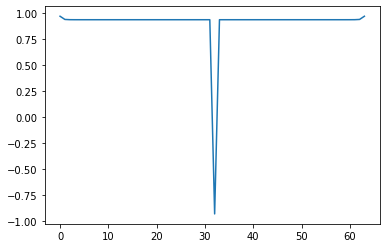

In [11]:
D = 6 # bond dimension of the MPS
N = 64 # number of spins in the system
J = 1.0 # interaction parameter
B = 2 # magnetic field strength
Jx = J * np.ones(N-1) # vector of interactions, one per spin-pair
Bz = B * np.ones(N) # local magnetic fields per spin
sx = np.array([[0,1],[1,0]])
ising_mpo = tn.FiniteTFI(Jx, Bz, dtype=np.complex128) # an MPO representation of the Hamiltonian for the TFI
mps = tn.FiniteMPS.random(D = [D]*(N-1), d = [2] * N, dtype=np.complex128) # an initial random MPS
dmrg = tn.FiniteDMRG(mps, ising_mpo) #DMRG interface
dmrg.run_one_site(num_sweeps = 4, verbose=1, precision=1E-10) # run DMRG optimization

# we now apply a spin flip to the center of the chain to create a non-eigenstate
mps.tensors[N//2] = tn.ncon([mps.tensors[N//2],sx],[[-1,1,-3],[-2,1]])
mps.position(N-1)
mps.position(0)
sz_obs = [np.real(measure_local(mps,sz))]
plt.plot(sz_obs[0])

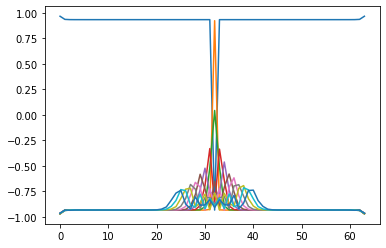

In [12]:
sz = np.diag([-1,1])
eye = np.eye(2)

# create the local hamiltonians used for time evolution later on
sxsx = J * tn.ncon([sx, sx],[[-1,-3],[-2,-4]])
h_left = sxsx + tn.ncon([sz, eye],[[-1,-3],[-2,-4]])*B + tn.ncon([eye, sz],[[-1,-3],[-2,-4]])*B/2
h_right = sxsx+ tn.ncon([sz, eye],[[-1,-3],[-2,-4]])*B/2 + tn.ncon([eye, sz],[[-1,-3],[-2,-4]])*B
h_bulk = sxsx + tn.ncon([sz, eye],[[-1,-3],[-2,-4]])*B/2 + tn.ncon([eye, sz],[[-1,-3],[-2,-4]])*B/2

plt.plot(sz_obs[0])
for n in range(100):
  mps = tebd(mps,[h_left, h_bulk, h_right],dt=0.05,max_truncation_error=1e-5)
  if n % 10 == 0:
    sz_obs.append(np.real(measure_local(mps,sz)))
    plt.plot(sz_obs[-1])


plt.show()

Time evolution of MPS is classical not efficient. During the evolution a lot of entanglement is created. This is reflected in the fact that the bond dimension of the MPS needs to grow to keep an accurate simulation. 

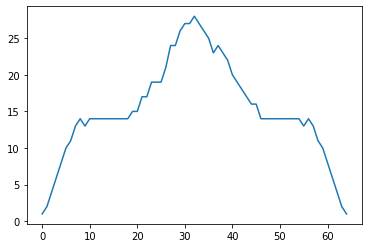

In [13]:
plt.plot(mps.bond_dimensions)

We can also perform a "global quench", which entails changing the entire hamiltonian before running time evolution:

SS-DMRG sweep=3/4, site=1/64: optimized E=(-136.00211539170542+0j)   

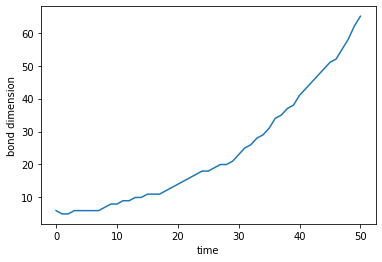

Text(0, 0.5, 'bond dimension')

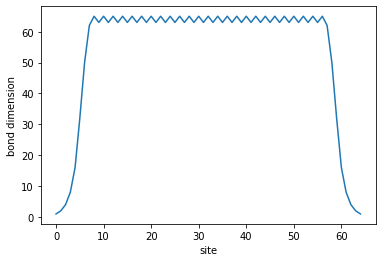

In [14]:
D = 6 # bond dimension of the MPS
N = 64 # number of spins in the system
J = 1.0 # interaction parameter
J2 = -J # we quench the interaction to twice its value
B = 2 # magnetic field strength

Jx = J * np.ones(N-1) # vector of interactions, one per spin-pair
Bz = B * np.ones(N) # local magnetic fields per spin
sx = np.array([[0,1],[1,0]])
ising_mpo = tn.FiniteTFI(Jx, Bz, dtype=np.complex128) # an MPO representation of the Hamiltonian for the TFI
mps = tn.FiniteMPS.random(D = [D]*(N-1), d = [2] * N, dtype=np.complex128) # an initial random MPS
dmrg = tn.FiniteDMRG(mps, ising_mpo) #DMRG interface
dmrg.run_one_site(num_sweeps = 4, verbose=1, precision=1E-10) # run DMRG optimization

sxsx = J2 * tn.ncon([sx, sx],[[-1,-3],[-2,-4]])
h_left = sxsx + tn.ncon([sz, eye],[[-1,-3],[-2,-4]])*B + tn.ncon([eye, sz],[[-1,-3],[-2,-4]])*B/2
h_right = sxsx+ tn.ncon([sz, eye],[[-1,-3],[-2,-4]])*B/2 + tn.ncon([eye, sz],[[-1,-3],[-2,-4]])*B
h_bulk = sxsx + tn.ncon([sz, eye],[[-1,-3],[-2,-4]])*B/2 + tn.ncon([eye, sz],[[-1,-3],[-2,-4]])*B/2

dt = 0.05;
nsteps = 50;

bond_dimensions = [mps.bond_dimensions[N//2]]

for step in range(nsteps):
    mps = tebd(mps,[h_left, h_bulk, h_right],dt,1e-5);
    bond_dimensions.append(mps.bond_dimensions[N//2])


plt.plot(bond_dimensions)
plt.xlabel('time')
plt.ylabel('bond dimension')
plt.show()
plt.plot(mps.bond_dimensions)
plt.xlabel('site')
plt.ylabel('bond dimension')

We can see that the bond dimension needs to grow far quicker compared to the local quench case. This is typically what limits an MPS simulation - when the bond dimensions grows too large, and we can no longer keep the tensors in memory.